<a href="https://colab.research.google.com/github/gabylinares123/Detection-with-PGNAA-project/blob/main/Detection_with_PGNAA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Heavy Metal Content in Environmental Samples through Neutron Activation (PGNAA)

## Getting acsess to necesary libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
from scipy import signal
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from google.colab import files
sns.set();

First, the necessary data to work with are uploaded:
  * Reference table of isotope energies
  * Gamma spectrum data of the samples

## Reading reference data

In [ ]:
ref = files.upload() # We upload the reference file

In [ ]:
spectrum = files.upload() # We upload our data file

In [ ]:
df = pd.read_excel("promptgammas.xls", index_col="A")
df.head()

,Isotope,Z,T,E(g),Unnamed: 5,Sigma,Unnamed: 7,Unnamed: 8,K0,Unnamed: 10,Unnamed: 11
A,,,,,,,,,,,
NaN,NaN,NaN,NaN,Text,Value,Text,Value,Uncertainty,Text,Value,Uncertainty
1.0,2-H,1.0,p,2223.24835(9),2223.248,0.3326(7),0.3326,0.0007,1.0000(21),1,0.0021
2.0,3-H,1.0,p,6250.243(3),6250.243,0.000519(7),0.000519,0.000007,0.001560(21),0.00156,0.000021
3.0,4-He,2.0,p,20520.46,20520.46,4.2E-11(12),0.0,0.0,3.2E-11(9),0.0,0.0
6.0,7-Li,3.0,p,477.595(3),477.595,0.00153(8),0.00153,0.00008,0.00067(4),0.000668,0.000035


In [ ]:
# Once upload, we arrange the data
df.columns = ["Isotope", "Z", "T", "E", "E (value)", "Sigma", "Sigma (value)",
             "Sigma uncertainty", "K0", "K0 (value)", "K0 uncertainty"]
df.dropna(inplace=True)
data = df[["Isotope", "Z", "E (value)", "Sigma (value)", "K0 (value)"]]

In [ ]:
data.head()

,Isotope,E (value),Sigma (value),K0 (value)
A,,,,
1.0,2-H,2223.248,0.3326,1
2.0,3-H,6250.243,0.000519,0.00156
3.0,4-He,20520.46,0.0,0.0
6.0,7-Li,477.595,0.00153,0.000668
6.0,7-Li,6768.81,0.00151,0.000659


In [ ]:
# We arrange the reference data

data.sort_values("E (value)", inplace=True)
data["E (value)"] = data["E (value)"].astype("float64")
data.head()

/home/roberth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/roberth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Isotope,E (value),Sigma (value),K0 (value)
A,,,,
203.0,204-Tl,6.000,0.00021,0.000003
170.0,171-Yb,9.156,0.0003,0.000005
127.0,128-I,10.396,0.0009,0.000022
133.0,134-Cs,11.245,0.142,0.00324
168.0,169-Yb,12.310,0.0009,0.000016


## Reading sample data

In [ ]:
spectrum = files.upload()

In [ ]:
# Original file data_original
data_original = pd.read_csv("/home/gaby/dataproy/Spektrum_1.csv") # Spektrum_1.Spe file in .csv format

# We skip unnecessary rows
spectrum = pd.read_csv("/home/gaby/dataproy/Spektrum_1.csv", skiprows = 5, skipfooter=2, engine='python')
spectrum.columns = ["Channel counts"]
spectrum.sort_values(by="Channel counts")
spectrum["Channel counts"] = spectrum["Channel counts"].astype("int64")

### Data suministrada. Sin modificaciones¶

In [ ]:
# Original data graph

fig1 = plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0,8191,8192), spectrum["Channel counts"])
plt.xlabel("Cahnnel",fontsize=20)
plt.ylabel("Counts",fontsize=20)
plt.title("Original Plot",fontsize=25)
plt.savefig("spectrum without corrections")
plt.show

## Energetic calibration of spectra

- All spectra have 8192 entries
- Each entry corresponds to the number of signals measured in a certain energy range (channel).
- Each channel therefore has an associated energy (energy range).
- A calibration function determines the assignment of the channel number to the energy.
- This function has the form:
E = a0 + a1 * C + a2 * C ^ 2, C = 1, ..., 8192, energy E in keV.


In [ ]:
# Energy adjust

# Readint the adjust parameters of original data
def parameters(data):
    """
    Reads the parameters of the last line of a Spektrum.Spe
    and stores them in the constants a0, a1 and a2.
    
    data = data original
    
    """
    
    a0, a1, a2 = np.array(data.iloc[-1][-1].split(' ')).astype("float64")
    return a0, a1, a2

# Computing energies
def Energy(data1, data2):
    """
    Returns the energy values for data2, using the parameters of data1

    data1 = original data (Spektrum.Spe)
    data2 = spectrum values by removing unnecessary rows

    Example: Energy(data_original, spectrum)
    
    """
    
    a0, a1, a2 = parameters(data1)
    Energy = a0 + a1 * data2.index + a2 * (data2.index)**2
    return Energy

# We define x-axis on the spectrum
Energies = Energy(data_original,spectrum)

In [ ]:
# We assign "Energy" to the correspongind column of the data

spectrum["Energy"] = Energy(data_original,spectrum)

### Plotting with energy corrected

In [ ]:
# We plot the spectrogram to see how it looks

fig2 = plt.figure(figsize=(8, 6))
plt.plot(spectrum.Energy, spectrum["Channel counts"])
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Counts",fontsize=20)
plt.title("Plot with energy corrections",fontsize=25)
plt.savefig("spectrum with energy corrections")
plt.show

These functions are used on a recurring basis with the other available spectra. After adjusting the energy values, the data are arranged in a single file to facilitate future readings.

In [ ]:
# We import the sample data base

spec_db= files.upload()
spectrums = pd.read_csv(spec_db)
spectrums.tail()

,Channel counts 1,Energy 1,Channel counts 2,Energy 2,Channel counts 3,Energy 3,Channel counts 4,Energy 4,Channel counts 5,Energy 5,...,Channel counts 21,Energy 21,Channel counts 22,Energy 22,Channel counts 23,Energy 23,Channel counts 24,Energy 24,Channel counts 25,Energy 25
8185,0,10889.060802,0,10889.060802,0,10889.060802,0,10889.060802,0,10889.060802,...,0,10889.060802,0,10889.060802,0,10889.060802,0,10889.060802,0,10889.060802
8186,0,10890.392730,0,10890.392730,0,10890.392730,0,10890.392730,0,10890.392730,...,0,10890.392730,0,10890.392730,0,10890.392730,0,10890.392730,0,10890.392730
8187,0,10891.724658,0,10891.724658,0,10891.724658,0,10891.724658,0,10891.724658,...,0,10891.724658,0,10891.724658,0,10891.724658,0,10891.724658,0,10891.724658
8188,0,10893.056586,0,10893.056586,0,10893.056586,0,10893.056586,0,10893.056586,...,0,10893.056586,0,10893.056586,0,10893.056586,0,10893.056586,0,10893.056586
8189,0,10894.388515,0,10894.388515,0,10894.388515,0,10894.388515,0,10894.388515,...,0,10894.388515,0,10894.388515,0,10894.388515,0,10894.388515,0,10894.388515


### Semi-log scale graph on Y-axis
In order to better appreciate the structure of the graph, it is useful to adjust the vertical scale logarithmically. This makes it possible to visualize the peaks of the spectra.

In [ ]:
# Graph log(counts) vs. energy

fig3 = plt.figure(figsize=(8, 6))
plt.yscale("log")
plt.plot(spectrum.Energy, spectrum["Channel counts"])
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("log(Counts)",fontsize=20)
plt.title("Plot with energy corrections and Y log axe",fontsize=25)
plt.savefig("semilog spectrum with energy corrections")
plt.show()

## Peak search
In order to identify peaks, the program must first recognize which ones to use. The parameters of the scipy.signal.find_peaks() function have been adjusted to discard noise and obtain the best peaks.

In [ ]:
# Finding peaks in the spectrum

# We separate the output in peaks and properties
peaks, properties = signal.find_peaks(spectrum.iloc[:, 0], 
                                      height=3000, threshold=200, distance=50, prominence=4000)

# We convert the peaks position into energy
a0, a1, a2 = parameters(data_original)
peaks_Energy = a0 + a1 * peaks + a2 * (peaks)**2

# The "propeties" variable is a dictionary with the following keys:
peak_heights, left_thresholds, right_thresholds, prominences, left_bases, right_bases = properties

print(len(peaks), 'peaks were found.')

### Picos encontrados

In [ ]:
# Graph of the found peaks

fig4 = plt.figure(figsize=(8, 6))
plt.yscale("log")
plt.plot(spectrum.Energy, spectrum.iloc[:, 0], label='Spectrum')
plt.plot(peaks_Energy, spectrum.iloc[:, 0][peaks], "x", label='Peaks')
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("log(Counts)",fontsize=20)
plt.title("Finding peaks",fontsize=25)
plt.legend()
plt.savefig("finding peaks")
plt.show()

## Identifying the sample peaks
In this part, the peaks of the sample are compared with the reference data to identify the isotope to which it belongs, and therefore, the elements that make up the sample.

In [ ]:
# We define a function that compares the peaks of the sample with the reference data

def composition_analysis(spectrum_sample, comparative_data):

    """
    Compare the peaks of the gamma-ray distribution in the sample to
    obtain its composition.

    Input : 
    --------
    spectrum_sample : numpy.ndarray (2D)
                      Gamma-ray spectrum of the sample
    comparative_data : numpy.ndarray
                      Reference values for each isotope and element.

    Return:
    -------
    List with all the composition.
    """
    Comp = []
    
    # Now we find similar isotopes for each given peak
    for E in peaks_Energy:
        n = []
        if E < 0:
            continue
        else:
            for isotope in comparative_data["E (value)"]:
                d = np.absolute(isotope - E)
                n.append(d)

        min_value = np.array(n).min()
        iso = comparative_data.Isotope[np.absolute(comparative_data["E (value)"] - E) == min_value ]
        Comp.append(iso.values[0])

    return np.array(Comp)

isotopes_found = composition_analysis(spectrum, data)[1]
print('The following isitopes were found: \n', isotopes_found)

## Comparing spectra of the samples

In [ ]:
# We define a new function that finds the similarity and difference between two spectrums

def comparative_analysis(spectrum_1, spectrum_2):
    """
    This function calculate the match grade between two spectrum peaks.

    Inputs
    -------
    spectrum_1 : array like
               This array contain the peaks on the first spectrum.
    spectrum_2 : array like
               This array contain the peaks on the second spectrum to compare

    Returns
    ---------
    Dict : The dictionary contain the following keys and values.
    Match : float
            Representing the equality between two spectrums in range 0% - 100%
    Discrepancies : Array like
            Contain the isotopes that make the differences between
            the two spectrums
    """
    # First, we ensure the two spectrums array have the same shape
    # Second, we evaluate if they have the same isotopes
    if spectrum_1.shape[0] != spectrum_2.shape[0] and spectrum_2.shape[0] > spectrum_1.shape[0]:
        while spectrum_1.shape[0] < spectrum_2.shape[0]:
            spectrum_1 = np.append(spectrum_1, np.nan)
            boolean_mask = np.isin(spectrum_2, spectrum_1)
    elif spectrum_1.shape[0] != spectrum_2.shape[0] and spectrum_2.shape[0] < spectrum_1.shape[0]:
        while spectrum_2.shape[0] < spectrum_1.shape[0]:
            spectrum_2 = np.append(spectrum_2, np.nan)
            boolean_mask = np.isin(spectrum_1, spectrum_2)
    else:
        boolean_mask = np.isin(spectrum_1, spectrum_2)

    # Now, let's compute the similitud grade
    grade = boolean_mask.sum() * 100 / len(boolean_mask)

    # Save the isotopes that make discrepancies from the first spectrum to second
    bad_ones = spectrum_1[~boolean_mask]

    # Return the results
    return dict([("Match",grade), ("Discrepancies",bad_ones)])

In [ ]:
# We obtain the composition of all spectrums
Spe_peaks = {}
for n in range(1, 26):
    spe_peak = composition_analysis(spectrums[[f"Channel counts {n}"]], data)
    Spe_peaks[f"Peaks {n}"] = spe_peak

Listo!


### Results
The data is stored in a DataFrame

In [ ]:
def comparative_results(Comp_spectrums):
    """
    Function to create the DataFrame and visualise its similarities
    
    Input :
    --------
    Comp_spectrums : Array-like
                     Array that contains all the isotopes of the sample
                     
    Return :
    ---------
    Pandas.Dataframe : Contains as values of index and columns of the peaks,
                       it is similar to a matrix
    """
    # Initial values
    i = 0
    array = np.empty((25,25))
    names = []
    
    for peak_1 in Comp_spectrums:
        j = 0
        for peak_2 in Comp_spectrums:
            # We do the comparative analysis between two spectrums and we save it in a position
            result = comparative_analysis(Comp_spectrums[peak_1], Comp_spectrums[peak_2])
            array[i,j] = result["Match"]
            j += 1
        names.append(peak_1)
        i += 1

    # Returns the entire DataFrame
    return pd.DataFrame(array, columns=names, index=names)

In [ ]:
Comp_results = comparative_results(Spe_peaks)
Comp_results.head()

,Peaks 1,Peaks 2,Peaks 3,Peaks 4,Peaks 5,Peaks 6,Peaks 7,Peaks 8,Peaks 9,Peaks 10,...,Peaks 16,Peaks 17,Peaks 18,Peaks 19,Peaks 20,Peaks 21,Peaks 22,Peaks 23,Peaks 24,Peaks 25
Peaks 1,100.000000,88.727273,86.392405,85.113269,82.844244,84.797297,86.241611,80.727273,87.868852,89.454545,...,84.363636,86.111111,83.916084,88.363636,84.363636,81.250000,85.090909,84.341637,89.454545,86.545455
Peaks 2,88.727273,100.000000,86.075949,84.142395,81.264108,83.108108,83.557047,77.289377,87.868852,88.321168,...,85.347985,86.805556,86.713287,84.615385,84.981685,82.738095,83.150183,82.206406,82.783883,85.347985
Peaks 3,86.392405,86.075949,100.000000,89.556962,84.650113,84.493671,86.708861,82.278481,89.240506,87.025316,...,79.113924,80.379747,82.594937,85.126582,82.594937,83.035714,83.544304,84.493671,85.443038,85.126582
Peaks 4,85.113269,84.142395,89.556962,100.000000,84.875847,83.818770,84.789644,78.964401,88.025890,87.378641,...,81.229773,83.495146,84.466019,82.200647,81.229773,84.523810,81.877023,85.113269,82.524272,85.760518
Peaks 5,82.844244,81.264108,84.650113,84.875847,100.000000,83.295711,83.295711,75.169300,85.778781,80.361174,...,79.006772,82.844244,81.941309,80.812641,79.232506,89.164786,79.006772,81.038375,79.458239,83.747178


## Creando agrupamientos de comparación

In [ ]:
# Evaluationg the differences in the samples

def unique_comp(Comp_spectrums):
    """
    Computes and returns all the isotopes in all the samples
    
    Input : 
    --------
    Comp_spectrums : Array-like
                     Array array that contains the isotope for each sample
    
    Return :
    ---------
    Array that contains all the different isotopes on the samples
    """
    
    # We obtain all the dictionary values in array-like shape
    components = np.array(list(Comp_spectrums.values()))
    
    # The previous array is two-dimensiona, we convert it into a one-dimensional
    all_comps = []
    for spec in components:
        tmp = spec.tolist()
        for e in tmp:
            all_comps.append(e)

    # For convenience, it is converted into a pandas.Series
    all_comp = pd.Series(all_comps)
    all_comp.drop_duplicates(inplace=True)
    all_comp = all_comp.reset_index()
    all_comp.drop("index", axis=1, inplace=True)
    
    # After that, into a simple array
    return all_comp.values.flatten()

In [ ]:
ac = unique_comp(Spe_peaks)

In [ ]:
sets = np.empty(25)
n = 0
for sample in Spe_peaks:
    set_lenght = len(Spe_peaks[sample])
    sets[n] = set_lenght
    n += 1
print(sets.max())

550.0


In [ ]:
# Normalizing previous arrays

def norm_sample(Comp_spectrums):
    """
    The arrays obtained from the sample composition may not be equal in size.
    This function normalizes them to arrays of the same size by filling with null values (np.nan).
    null values (np.nan)
    
    Input :
    --------
    Comp_spectrums : Array-like
                     Array containing the isotopes of each sample
    
    Return :
    ---------
    Dict :  Dictionary with all isotopes of spectra with the same dimension
    """
    # We find the larger array
    sets = np.empty(25)
    n = 0
    for sample in Comp_spectrums:
        set_lenght = len(Comp_spectrums[sample])
        sets[n] = set_lenght
        n += 1
    max_shape = sets.max()
    
    # Normalizing the arrays
    Norm_spectrums = Comp_spectrums.copy()
    for sample in Norm_spectrums:
        while len(Norm_spectrums[sample]) < max_shape:
            Norm_spectrums[sample] = np.append(Norm_spectrums[sample], np.nan)
    
    return Norm_spectrums

In [ ]:
Norm_spectrums = norm_sample(Spe_peaks)

In [ ]:
one_hot = np.empty((25, 210), dtype=bool)
i = 0
for sample in Spe_peaks:
    tmp = []
    j = 0
    for e in Spe_peaks[sample]:
        if not(e in tmp):
            tmp.append(e)
            one_hot[i,j] = e in ac
            j += 1
        else:
            continue
    i += 1


In [ ]:
# We create a new set of data with the previous results

T_comp = pd.DataFrame(one_hot, columns=ac, index = Spe_peaks.keys())
T_comp.replace([True, False], [1, 0], inplace=True)
T_comp

,151-Nd,194-Ir,80-Br,160-Tb,176-Lu,140-La,188-Re,158-Gd,168-Er,134-Cs,...,143-Ce,131-Te,87-Kr,107-Pd,117-Sn,208-Pb,195-Pt,193-Os,13-C,187-Os
Peaks 1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
Peaks 2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,0,0,0
Peaks 3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
Peaks 4,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,0,0
Peaks 5,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,0,0,1,1
Peaks 6,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
Peaks 7,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,0,0,0,1,1
Peaks 8,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Peaks 9,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,1,1
Peaks 10,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
cluster = AgglomerativeClustering(distance_threshold = 0, n_clusters=None)

In [ ]:
cluster.fit(T_comp)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [ ]:
# Function to visualize the dendogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs, labels=T_comp.index, leaf_rotation=45)

### Graficando el dendograma

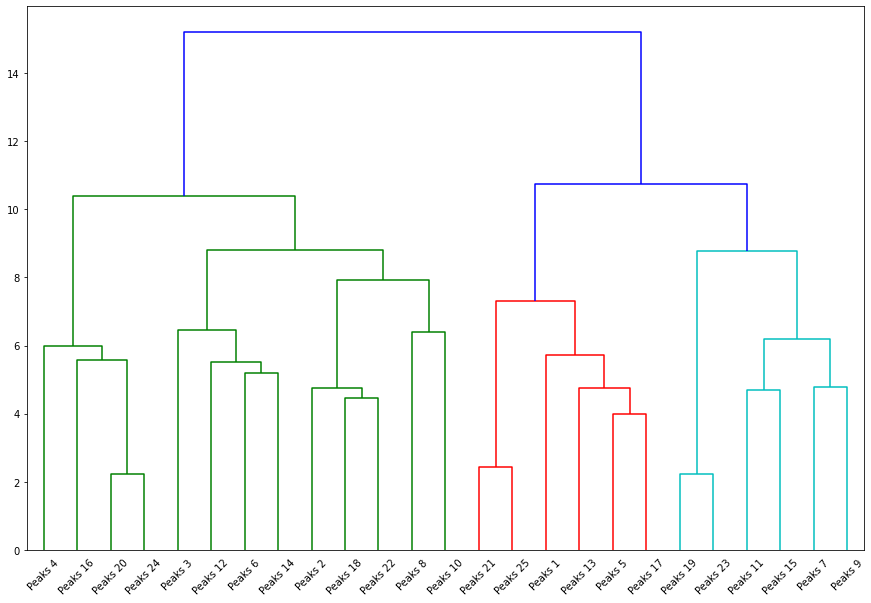

In [ ]:
# Dendogram

fig5 = plt.figure(figsize=(15, 10))
dictionary = plot_dendrogram(cluster, truncate_mode='lastp', p=25)
plt.savefig("Dendrograma")

## Computing peaks area
To determine the concentration of each of the elements identified in the sample, the area of the peaks is determined, since this measure is proportional to the mass. Among the procedures, it is proposed to divide the peaks into smaller pieces with regular shapes and calculate the area of each piece. The sum of these quantities results in an approximation of the peak area.

We could not finish this part.

In [ ]:
# Some peak parameters are evaluated

# Prominencia de pico
peaks_prominence = signal.peak_prominences(spectrum.iloc[:, 0], peaks)

## We separate the prominence of the peaks, from left and right
peaks_prominences, left_bases2, right_bases2 = peaks_prominence

In [ ]:
# We compute the peak width

## The rel_height parameter is the relative height. A value close to 1 is taken
peaks_width = signal.peak_widths(spectrum.iloc[:, 0], peaks, rel_height=0.98, prominence_data=None, wlen=None)

## The variables returned by peak_widths
widths, width_heights, left_ips, right_ips = peaks_width

## Energy at the beginning and end of the peaks
start_peaks = a0 + a1 * left_ips + a2 * (left_ips)**2
final_peaks = a0 + a1 * right_ips + a2 * (right_ips)**2

### Visualizing peak's width

In [ ]:
# Graph of the peaks found and the width of each one. Test output

fig6 = plt.figure(figsize=(8, 6))
plt.yscale("log")
plt.plot(spectrum.Energy, spectrum.iloc[:, 0], label='Spectrum')
plt.plot(peaks_Energy, spectrum.iloc[:, 0][peaks], "x", label='Peaks')
plt.hlines(peaks_width[1], start_peaks, final_peaks, color="C2", label='Widht')
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("log(Counts)",fontsize=20)
plt.title("Peaks width",fontsize=25)
plt.legend()
plt.savefig("peaks and widht")
plt.show()

In [ ]:
# The peaks are divided into segments

## The scipy.sinal.peak_widths function is used with different values of rel_height, to divide the area of the peaks into trapezoids and a triangle.

def slice_peaks(n):
    """
    Encuentra el ancho de pico con rel_height = n y calcula las energías al inicio y final del pico
    Input : 
    --------
    n: número entre 0 y 1 que representa la altura relativa de los picos y toma una porción de éste
    Return : 
    --------
    Ancho de los pedazos seleccionados, altura de los pedazos, inicio y final de la longitud de los trozos
    """
    
    # Determines the power setting parameters
    a0, a1, a2 = parameters(data_original)
    
    # Calculate the width of the beak portion.
    piece_width, width_heights, left_ips, right_ips = signal.peak_widths(spectrum.iloc[:, 0], 
                                                                         peaks, rel_height=n, 
                                                                         prominence_data=None, wlen=None)

    # Calculates the energy where the portion of the peaks starts and ends.
    start_peaks = a0 + a1 * left_ips + a2 * (left_ips)**2
    final_peaks = a0 + a1 * right_ips + a2 * (right_ips)**2
    
    return piece_width, width_heights, start_peaks, final_peaks


## Length of the pieces. They will be the bases of the trapezoids
width_areas = slice_peaks(0.1)[0], slice_peaks(0.2)[0], slice_peaks(0.3)[0], slice_peaks(0.4)[0], slice_peaks(0.5)[0], slice_peaks(0.6)[0], slice_peaks(0.7)[0], slice_peaks(0.8)[0], slice_peaks(0.9)[0], slice_peaks(0.98)[0]


## Height of the pieces. Subtract the upper height minus the immediate lower height
height_areas = np.array(properties[peak_heights]) - slice_peaks(0.1)[1], slice_peaks(0.1)[1] - slice_peaks(0.2)[1], slice_peaks(0.2)[1] - slice_peaks(0.3)[1], slice_peaks(0.3)[1] - slice_peaks(0.4)[1], slice_peaks(0.4)[1] - slice_peaks(0.5)[1], slice_peaks(0.5)[1] - slice_peaks(0.6)[1], slice_peaks(0.6)[1] - slice_peaks(0.7)[1], slice_peaks(0.7)[1] - slice_peaks(0.8)[1], slice_peaks(0.8)[1] - slice_peaks(0.9)[1], slice_peaks(0.9)[1] - slice_peaks(0.98)[1]


## The area of the peaks is calculated by adding up the area of each piece.
peaks_areas = (width_areas[0] * height_areas[0]
               + (width_areas[0] + width_areas[1]) * height_areas[1]
               + (width_areas[1] + width_areas[2]) * height_areas[2]
               + (width_areas[2] + width_areas[3]) * height_areas[3] 
               + (width_areas[3] + width_areas[4]) * height_areas[4] 
               + (width_areas[4] + width_areas[5]) * height_areas[5] 
               + (width_areas[5] + width_areas[6]) * height_areas[6] 
               + (width_areas[6] + width_areas[7]) * height_areas[7] 
               + (width_areas[7] + width_areas[8]) * height_areas[8] 
               + (width_areas[8] + width_areas[9]) * height_areas[9]) / 2

peaks_areas = np.array([peaks_areas])
total_area = peaks_areas.sum()

print('Área de picos: \n', peaks_areas)
print('Área total: \n', total_area)

### Área de los picos

In [ ]:
# Graphical display of the procedure for calculating the area of the peaks

# Length of vertical line to be plotted
contour_heights = spectrum.iloc[:, 0][peaks] - peaks_prominences

# Plotting

fig7 = plt.figure(figsize=(8, 6))
plt.yscale("log")
plt.plot(spectrum.Energy, spectrum.iloc[:, 0], label='Spectrum')
plt.plot(peaks_Energy, spectrum.iloc[:, 0][peaks], "x", label='Peaks')
plt.hlines(*slice_peaks(0.1)[1:], color="C1", label='10% relative height')
plt.hlines(*slice_peaks(0.2)[1:], color="C2", label='20% relative height')
plt.hlines(*slice_peaks(0.3)[1:], color="C3", label='30% relative height')
plt.hlines(*slice_peaks(0.4)[1:], color="C4", label='40% relative height')
plt.hlines(*slice_peaks(0.5)[1:], color="C5", label='50% relative height')
plt.hlines(*slice_peaks(0.6)[1:], color="C6", label='60% relative height')
plt.hlines(*slice_peaks(0.7)[1:], color="C7", label='70% relative height')
plt.hlines(*slice_peaks(0.8)[1:], color="C8", label='80% relative height')
plt.hlines(*slice_peaks(0.9)[1:], color="C9", label='90% relative height')
plt.hlines(*slice_peaks(0.98)[1:], color="C10", label='98% relative height')
plt.vlines(x=spectrum.Energy[peaks], ymin=contour_heights, ymax=spectrum.iloc[:, 0][peaks], color="C1", ls ="--", label='Prominence')
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("log(Counts)",fontsize=20)
plt.title("Finding peaks areas",fontsize=25)
plt.xlim(3140, 3200)
plt.ylim(2500, 8000)
plt.legend()
plt.savefig("finding peaks areas zoom.png")
plt.show()

## Determining the concentration of the components
Once the peak area is known, it can be associated with the concentration of the sample component. A proportionality of the form is proposed:

$Ci = (Zi * Ai) / Area$

Ci: Concentration of peak i
Zi: Atomic number of the isotope identified
Ai: Area of peak i

In [ ]:
# Identifying the atomic number, Z, in a manner similar to isotope identification

def Z_number(spectrum_sample, comparative_data):
    """
    Function similar to composition_analysis(spectrum_sample, comparative_data)
    Compares the sample peaks to obtain and gets the corresponding Z number.

    Input : 
    --------
    spectrum_sample : numpy.ndarray (2D)
                      Gamma energy spectrum of the sample
    comparative_data : numpy.ndarray
                      Table of data with the reference values for each isotope and/or element
                      and/or element

    Return:
    -------
    List with all Z
    """
    Z = []
    
    # Z isotopes that resemble the given peak are searched for.
    for E in peaks_Energy:
        n = []
        if E < 0:
            continue
        else:
            for isotope in comparative_data["E (value)"]:
                d = np.absolute(isotope - E)
                n.append(d)

        min_value = np.array(n).min()
        iso = comparative_data.Z[np.absolute(comparative_data["E (value)"] - E) == min_value ]
        Z.append(iso.values[0])

    return np.array(Z)

# Test output
Z = Z_number(spectrum, data)
print('Atomic number of the identified isotopes: \n', Z)

In [ ]:
# Determining the concentration of compounds. Basically: Ci = (Zi * Ai)/Area.

concentracion = (Z * peaks_areas) / total_area

print('Concentrations: \n', concentracion)

In [ ]:
# Data are arranged to the same type
I = np.array([isotopes_found])

# Isotope table and concentrations
tabla = np.c_[I.T, concentration.T]

# It is converted into a DataFrame
concentration_results = pd.DataFrame(tabla)

# Arranging column information
concentration_results.columns = ["Isótopo", "Concentración"]
concentration_results.to_csv('sample1.csv')

print(concentration_results)

**Work by:**
J. Cammarata, V. Guzman, M. Linares, L. Manrique, L. Marcano, R. Marcano

**Tutor:**
A. Romero
